In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
def inner_rounder(x):
    if type(x) != float:
        pass
    else:
        x = np.round(x, 2)
    return x


def rounder(dataframe):
    for col in dataframe.columns.values:
        dataframe[col] = dataframe[col].apply(inner_rounder)
    return dataframe


def median_filler(features):
    for col in features.columns.values:
        features[col].fillna(features[col].median(), inplace=True)
    return features


def standard_scalling(features):
    columns = features.columns.values
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features), columns=columns)
    return features


def pca_executor(X, n_components, show=True):
    pca = PCA(n_components=n_components)
    modelPCA = pca.fit_transform(X)
    if show == True:
        print('\nExplained variance: ', 100 * pca.explained_variance_ratio_)
        print("\nData  percentage:", 100 * sum(pca.explained_variance_ratio_[:n_components]))
        sns.barplot(x=np.arange(1, n_components + 1),
                    y=pca.explained_variance_ratio_, color='blue')
        plt.xlabel('% explained')
        plt.show()

    X_pca = pd.DataFrame(modelPCA)
    return X_pca


def some_preprocessing_pipeline(features):
    features = standard_scalling(features)
    features = median_filler(features)
    features = rounder(features)
    features = pca_executor(features, 40)
    return features

In [4]:
test_data = pd.read_csv("test_data.csv")
test_data = test_data.set_index('Unnamed: 0')
test_data.Activity = test_data.Activity.replace({'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5})
test_data.head()

Activity  angle(X,gravityMean)  ...  tGravityAccMag-std()  void()
Unnamed: 0                                  ...                              
0                  2             -1.574191  ...              1.669987     1.0
1                  5             -1.568669  ...             -0.544652     2.0
2                  0             -1.548333  ...              2.024442     3.0
3                  3             -1.574094  ...              0.550414     2.0
4                  0             -1.548333  ...              2.024442     3.0

[5 rows x 572 columns]

In [5]:
X = test_data.iloc[:, 1:]
y = test_data['Activity']
print(X.head())

            angle(X,gravityMean)  ...  void()
Unnamed: 0                        ...        
0                      -1.574191  ...     1.0
1                      -1.568669  ...     2.0
2                      -1.548333  ...     3.0
3                      -1.574094  ...     2.0
4                      -1.548333  ...     3.0

[5 rows x 571 columns]



Explained variance:  [50.26719044  6.6312341   3.48966322  3.11120781  2.34033729  1.88185903
  1.23489878  1.21409168  0.98596776  0.89574359  0.8141992   0.7232738
  0.69614624  0.65059977  0.61826011  0.55591677  0.5424559   0.51420312
  0.48748227  0.48383905  0.45512335  0.44195675  0.43754128  0.42640207
  0.41459974  0.40885887  0.38702882  0.37071235  0.35965265  0.34553665
  0.33870296  0.32649897  0.31700039  0.30545209  0.29602282  0.29358362
  0.28387933  0.27030559  0.26859211  0.26037956]

Data  percentage: 85.14639989801414


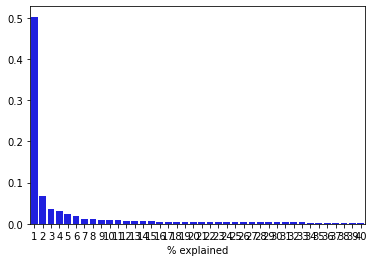

In [6]:
X = some_preprocessing_pipeline(X)

In [7]:
X.head()
y.head()

Unnamed: 0
0    2
1    5
2    0
3    3
4    0
Name: Activity, dtype: int64

In [8]:
X, y = np.array(X), np.array(y)

In [9]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

test_dataset = ClassifierDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())

In [10]:
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [11]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_5 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.layer_1(x)
        
        x = self.layer_2(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_5(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [12]:
device = 'cpu'
model = torch.load('model_final_gitara.pt')
model.eval()

MulticlassClassification(
  (layer_1): Linear(in_features=40, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=32, bias=True)
  (layer_5): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [13]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

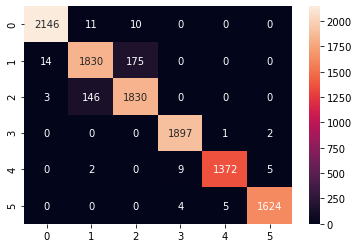

In [14]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True , fmt='g')

In [15]:
print(classification_report(y, y_pred_list))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2167
           1       0.92      0.91      0.91      2019
           2       0.91      0.92      0.92      1979
           3       0.99      1.00      1.00      1900
           4       1.00      0.99      0.99      1388
           5       1.00      0.99      1.00      1633

    accuracy                           0.97     11086
   macro avg       0.97      0.97      0.97     11086
weighted avg       0.97      0.97      0.97     11086



In [18]:
predicted = y_pred_list
print(np.mean(predicted == test_data.Activity))

0.9650911058993324
